## Library import

In [230]:
import numpy as np
import pandas as pd
import random
from time import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean, stdev

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

pd.options.display.precision = 2

In [156]:
from sklearn.datasets import load_boston

In [157]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    # Tensorflow
    #tf.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

In [226]:
#https://qiita.com/futakuchi0117/items/72ce4afae9adcccd6e18
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
import lightgbm as lgb

reg_dict = {"LinearRegression": LinearRegression(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=SEED),
            "RANSACRegressor": RANSACRegressor(random_state=SEED),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=SEED, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=SEED),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
            "LGBMRegressor": lgb.LGBMRegressor(n_jobs=-1, random_state=SEED),
                    }

## Data loading

In [158]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [159]:
def load_train():
    #_df = pd.read_csv('train.csv')
    boston = load_boston()
    _df = pd.DataFrame(boston.data, columns=boston.feature_names)
    _df['price'] = boston.target
    _df = _df[:300]
    
    _df = reduce_mem_usage(_df)
    gc.collect()
    
    return _df

df_train = load_train()

Mem. usage decreased to  0.01 Mb (74.7% reduction)


In [160]:
def load_test():
    #_df = pd.read_csv('test.csv')
    boston = load_boston()
    _df = pd.DataFrame(boston.data, columns=boston.feature_names)
    _df = _df[300:]
    
    _df = reduce_mem_usage(_df)
    gc.collect()
    
    return _df

df_test = load_test()

Mem. usage decreased to  0.01 Mb (74.5% reduction)


In [206]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,6.32e-03,18.0,2.31,0.0,0.54,6.57,65.19,4.09,1.0,296.0,15.3,397.00,4.98,24.00
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.88,4.97,2.0,242.0,17.8,397.00,9.14,21.59
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.09,4.97,2.0,242.0,17.8,392.75,4.03,34.69
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.81,6.06,3.0,222.0,18.7,394.75,2.94,33.41
4,6.90e-02,0.0,2.18,0.0,0.46,7.15,54.19,6.06,3.0,222.0,18.7,397.00,5.33,36.19


In [207]:
df_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
300,0.04,70.0,2.24,0.0,0.40,6.87,47.41,7.83,5.0,358.0,14.80,390.75,6.07
301,0.04,34.0,6.09,0.0,0.43,6.59,40.41,5.49,7.0,329.0,16.09,395.75,9.50
302,0.09,34.0,6.09,0.0,0.43,6.50,18.41,5.49,7.0,329.0,16.09,383.50,8.67
303,0.10,34.0,6.09,0.0,0.43,6.98,17.70,5.49,7.0,329.0,16.09,390.50,4.86
304,0.06,33.0,2.18,0.0,0.47,7.23,41.09,4.02,7.0,222.0,18.41,393.75,6.93


In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     300 non-null    float16
 1   ZN       300 non-null    float16
 2   INDUS    300 non-null    float16
 3   CHAS     300 non-null    float16
 4   NOX      300 non-null    float16
 5   RM       300 non-null    float16
 6   AGE      300 non-null    float16
 7   DIS      300 non-null    float16
 8   RAD      300 non-null    float16
 9   TAX      300 non-null    float16
 10  PTRATIO  300 non-null    float16
 11  B        300 non-null    float16
 12  LSTAT    300 non-null    float16
 13  price    300 non-null    float16
dtypes: float16(14)
memory usage: 8.3 KB


In [164]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 300 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     206 non-null    float16
 1   ZN       206 non-null    float16
 2   INDUS    206 non-null    float16
 3   CHAS     206 non-null    float16
 4   NOX      206 non-null    float16
 5   RM       206 non-null    float16
 6   AGE      206 non-null    float16
 7   DIS      206 non-null    float16
 8   RAD      206 non-null    float16
 9   TAX      206 non-null    float16
 10  PTRATIO  206 non-null    float16
 11  B        206 non-null    float16
 12  LSTAT    206 non-null    float16
dtypes: float16(13)
memory usage: 5.4 KB


## Data analysis

In [165]:
def corr(df):
    values = 1 - squareform(pdist(df.T, 'correlation'))
    return pd.DataFrame(values, columns=df.columns, index=df.columns)

Text(0.5, 1.0, 'Train')

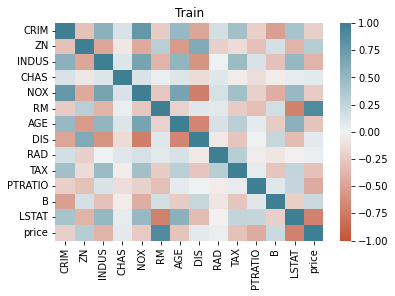

In [166]:
p = sns.heatmap(corr(df_train), vmax=1, vmin=-1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
p.set_title('Train')

Text(0.5, 1.0, 'Test')

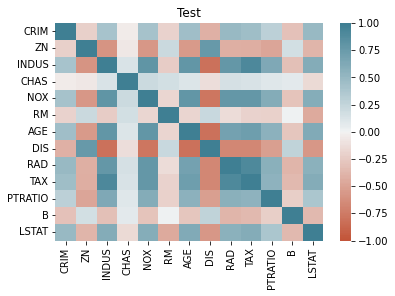

In [167]:
p = sns.heatmap(corr(df_test), vmax=1, vmin=-1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
p.set_title('Test')

In [168]:
def plot_all_cols(df):
    num_plot_col = 4
    num_plot_row = round(len(df.columns) / num_plot_col)
    i = 0
    for col in df.columns:
        col_type = df[col].dtypes
        
        if i == 0:
            fig = plt.figure(figsize=(13,2))
            plt.subplots_adjust(wspace=0.8)
            
        ax = fig.add_subplot(1, num_plot_col, i + 1)
        ax.set_title(col)
        if col_type in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            sns.distplot(df[col], bins=50, kde=True, ax=ax)
        elif col_type in ['bool']:
            sns.countplot(data=df, x=col, ax=ax)
        elif col_type in ['object']:
            sns.countplot(data=df, x=col, ax=ax)
            
        i += 1
        if i == num_plot_col:
            plt.show()
            i = 0

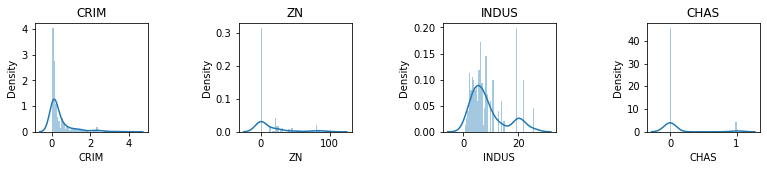

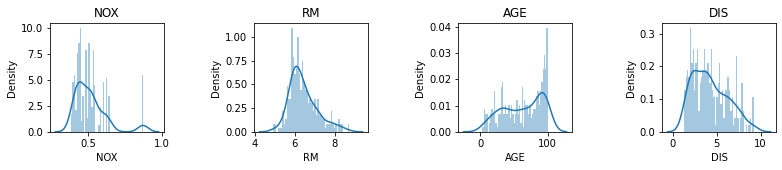

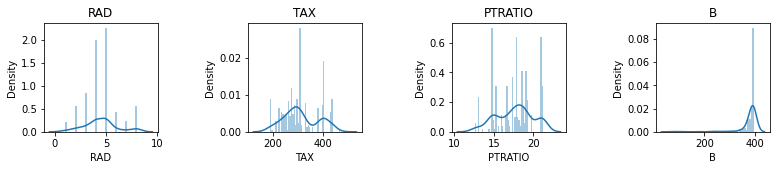

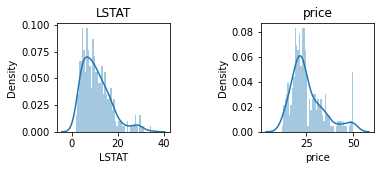

In [169]:
plot_all_cols(df_train)

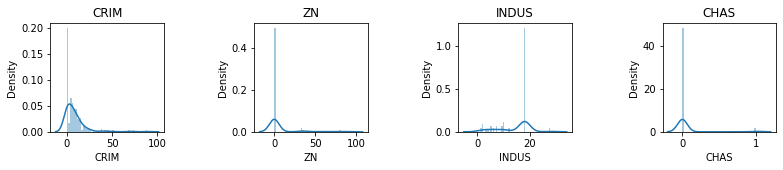

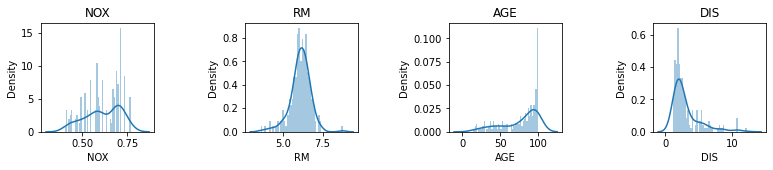

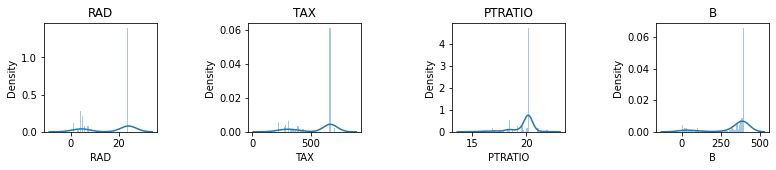

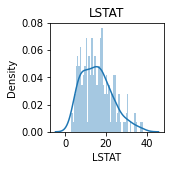

In [170]:
plot_all_cols(df_test)

In [171]:
def plot_pair(df, y_label):
    num_plot_col = 4
    num_plot_row = round(len(df.columns) / num_plot_col)
    i = 0
    for col in df.columns:
        col_type = df[col].dtypes
        
        if i == 0:
            fig = plt.figure(figsize=(13,2))
            plt.subplots_adjust(wspace=0.8)
            
        ax = fig.add_subplot(1, num_plot_col, i + 1)
        ax.set_title(col)
        if col_type in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            sns.scatterplot(data=df, x=col, y=y_label, ax=ax, alpha=0.2)
        elif col_type in ['bool']:
            sns.stripplot(data=df, x=col, y=y_label, ax=ax)
        elif col_type in ['object']:
            sns.stripplot(data=df, x=col, y=y_label, ax=ax)
            
        i += 1
        if i == num_plot_col:
            plt.show()
            i = 0

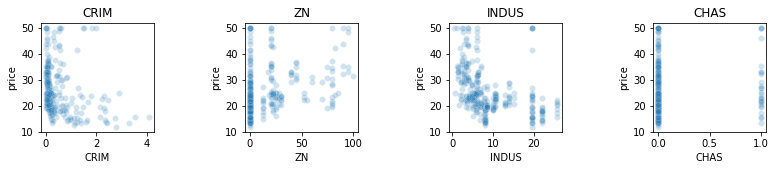

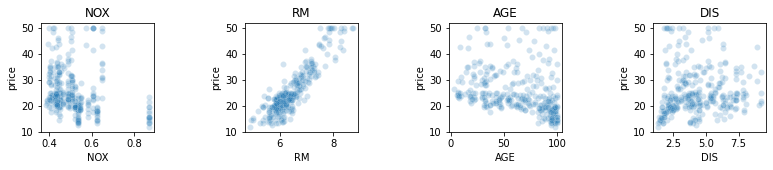

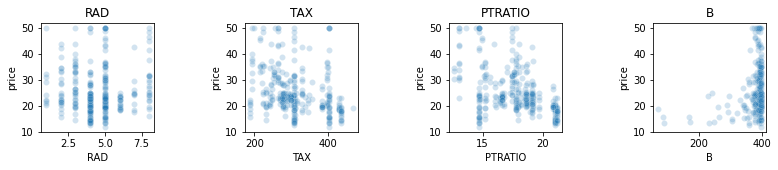

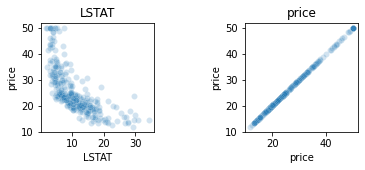

In [172]:
plot_pair(df_train, 'price')

## Functions fot multi varidation

In [175]:
NFOLD = 5

In [173]:
def get_scores(y, y_preds):
    scores = {}
    scores['MAE'] = mean_absolute_error(y, y_preds)
    scores['MSE'] = mean_squared_error(y, y_preds)
    scores['RMSE'] = mean_squared_error(y, y_preds, squared=False)
    scores['R2'] = r2_score(y, y_preds)
    return scores

In [178]:
def MyVaridation(X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train, y_train)
    
    y_train_predict = model.predict(X_train)
    scores_train = get_scores(y_train, y_train_predict)
    
    y_test_predict = model.predict(X_test)
    scores_test = get_scores(y_test, y_test_predict)

    return scores_train, scores_test

In [228]:
def MultiVaridation(X, y, model, scalar=False):
    time_start = time()
    
    if scalar == True:
        s = StandardScaler()
        X = s.fit_transform(X)
        
    df_scores_train = pd.DataFrame([])
    df_scores_test = pd.DataFrame([])
    
    kf = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        scores_train, scores_test = MyVaridation(X_train, X_test, y_train, y_test, model)
        
        df_scores_train = pd.concat([df_scores_train, pd.DataFrame(scores_train,index=[len(df_scores_train)])])
        df_scores_test = pd.concat([df_scores_test, pd.DataFrame(scores_test,index=[len(df_scores_test)])])
        
    desc_train = df_scores_train.describe()
    desc_test = df_scores_test.describe()
    
    for score in desc_train.columns:
        print('Train {0}: {1:.4f}+/-{2:.4f}'.format(score, desc_train.at['mean',score], desc_train.at['std',score]))
        print('Test  {0}: {1:.4f}+/-{2:.4f}'.format(score, desc_test.at['mean',score], desc_test.at['std',score]))
        
    elapsed_time = time() - time_start
    print('Elapsed time: {0:.2f}'.format(elapsed_time))

In [231]:
X = df.drop(columns=['price']).values
y = df['price'].values
for reg_name in reg_dict:
    print(f'Model: {reg_name}')
    MultiVaridation(X, y, reg_dict[reg_name])
    print('---')

Model: LinearRegression
Train MAE: 3.2686+/-0.0624
Test  MAE: 3.3885+/-0.2094
Train MSE: 21.7212+/-0.5304
Test  MSE: 23.4886+/-2.0601
Train RMSE: 4.6603+/-0.0570
Test  RMSE: 4.8428+/-0.2121
Train R2: 0.7423+/-0.0104
Test  R2: 0.7152+/-0.0419
Elapsed time: 0.0
---
Model: Ridge
Train MAE: 3.2594+/-0.0714
Test  MAE: 3.3804+/-0.2284
Train MSE: 21.9140+/-0.5026
Test  MSE: 23.7111+/-1.7375
Train RMSE: 4.6810+/-0.0538
Test  RMSE: 4.8668+/-0.1776
Train R2: 0.7400+/-0.0106
Test  R2: 0.7122+/-0.0424
Elapsed time: 0.0
---
Model: Lasso
Train MAE: 3.6120+/-0.0443
Test  MAE: 3.7128+/-0.4146
Train MSE: 26.6566+/-0.3629
Test  MSE: 28.6693+/-3.8331
Train RMSE: 5.1629+/-0.0351
Test  RMSE: 5.3451+/-0.3522
Train R2: 0.6836+/-0.0151
Test  R2: 0.6554+/-0.0353
Elapsed time: 0.0
---
Model: ElasticNet
Train MAE: 3.5913+/-0.0813
Test  MAE: 3.6689+/-0.3710
Train MSE: 26.3398+/-0.3581
Test  MSE: 27.8910+/-3.0993
Train RMSE: 5.1321+/-0.0349
Test  RMSE: 5.2747+/-0.2916
Train R2: 0.6875+/-0.0105
Test  R2: 0.6640+/-0